In [24]:
from qiskit import QuantumCircuit, execute
from qiskit.circuit import ParameterVector
from qiskit.circuit.random import random_circuit
import random
from qiskit import Aer
from qiskit.aqua.components.optimizers import ADAM
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
import matplotlib.pyplot as plt
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

Prepare 4 random 4-qubit quantum states of your choice.
Create and train a variational circuit that transforms input states into predefined output states. Namely
if random state 1 is provided, it returns state |0011>
if random state 2 is provided, it returns state |0101>
if random state 3 is provided, it returns state |1010>
if random state 4 is provided, it returns state |1100>
What would happen if you provided a different state?

Analyze and discuss the results.

In [54]:
def generate_random_circuits(seed1,seed2,seed3,seed4):
    qc1 = random_circuit(4, 2, max_operands=3, seed=seed1)
    qc2 = random_circuit(4, 2, max_operands=3, seed=seed2)
    qc3 = random_circuit(4, 2, max_operands=3, seed=seed3)
    qc4 = random_circuit(4, 2, max_operands=3, seed=seed4)
    return [qc1,qc2,qc3,qc4]

def get_prob_distribution(bound_circuit,backend):
    #Assign parameters using the assign_parameters method
    #print(len(params), circuit.num_parameters)
    bound_circuit.measure_all()
    raw_distrubution = execute(bound_circuit,backend,shots=1000).result()
    print(raw_distrubution)
    for key in raw_distrubution.keys():
        raw_distrubution[key] = raw_distrubution[key]/1000
    return raw_distrubution


def objective_function(circuit, label, params, epsilon=0.0005):
    cost_iteration = 0
    #for _ in range(0,100):
    new_circuit=circuit.copy()
    new_circuit.append(generate_anzats(n,num_layers,params),[0,1,2,3])
    distr = get_prob_distribution(new_circuit, Aer.get_backend('qasm_simulator'))
    if(label in distr):
        cost_iteration += np.log(max(epsilon,distr[label]))
    else:
        cost_iteration += np.log(epsilon)            
    cost_iteration = (-1)*(cost_iteration)
    #print("te cost of this iteration was: " + str(cost_iteration))
    return cost_iteration

def train(circuit, label, init_params):
    optimizer = ADAM(maxiter=5, )
    object_funct = lambda params: objective_function(circuit, label, params)
    opt_params, value, _ = optimizer.optimize(len(init_params), object_funct, initial_point=init_params)
    return opt_params

def generate_anzats(n_qubits,n_layers,parameters):
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    #parameters = ParameterVector('θ', (n_qubits*(n_layers+1)))
    circuit = QuantumCircuit(n_qubits)

    for layer in range(n_layers):
        for i in range(n_qubits):
            circuit.ry(parameters[n_qubits*layer+i], i)

        #Appending the entangling Controlled gates
        for i in range(n_qubits):
            circuit.cz(i,(i+1)%n_qubits)

    #Appending one additional layer of parameterized Ry gates
    for i in range(n_qubits):
        circuit.ry(parameters[n_qubits*(n_layers)+i], i)
    circuit.barrier()
    return circuit


In [48]:
seed1 = 1
seed2 = 2
seed3 = 3
seed4 = 4
n = 4
num_layers = 2
qc = QuantumCircuit(9)
circuits = generate_random_circuits(seed1,seed2,seed3,seed4)
labels = ["0011","0101", "1010", "1100"]
circuit = circuits[0]
param_list = [random.randint(0,20) for x in range(0,(n*(num_layers+1)))]
#opt_parameters = train(circuit, "0011", param_list)
#distribution = get_prob_distribution(circuit, Aer.get_backend('qasm_simulator'), opt_parameters)
#print(distribution)


In [49]:
# instatiate the optimizer
object_funct = lambda params: objective_function(circuit, "0011", params)
options = {'c1': 0.5, 'c2': 0.5, 'w': 0.5}
optimizer = GlobalBestPSO(n_particles=12, dimensions=12, options=options)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(object_funct, 1)

2021-09-12 11:03:35,420 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/1/home/luis/.local/lib/python3.8/site-packages/qiskit/circuit/instruction.py:99: DeprecationWarning: Gate param type <class 'numpy.ndarray'> is being deprecated as of 0.16.0, and will be removed no earlier than 3 months after that release date. Considering creating your own Gate subclass with the method validate_parameter  to allow this param type.
  self.params = params  # must be at last (other properties may be required for validation)
2021-09-12 11:03:35,433 - qiskit.transpiler.runningpassmanager - INFO - Pass: UnrollCustomDefinitions - 0.87404 (ms)
2021-09-12 11:03:35,434 - qiskit.transpiler.passes.basis.basis_translator - INFO - Begin BasisTranslator from source basis {('crz', 2), ('measure', 1), ('swap', 2), ('ry', 1), ('barrier', 4), ('cx', 2), ('cz', 2), ('rz', 1)} to target basis {'y', 'sx', 'delay', 'h', 'mcx

TypeError: only size-1 arrays can be converted to Python scalars

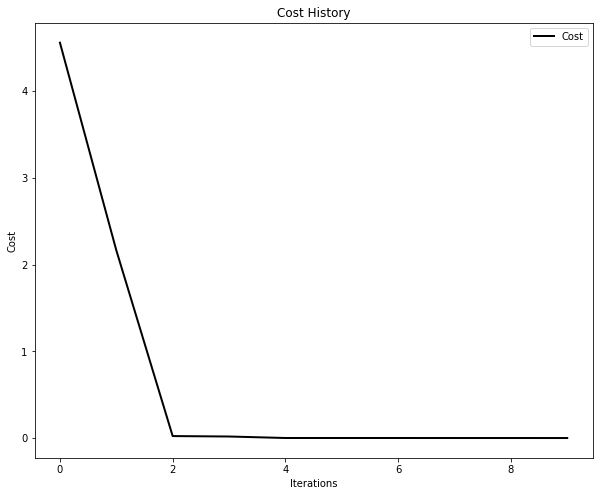

In [27]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()